<a href="https://colab.research.google.com/github/monurcan/3800/blob/master/AO2019_MonteCarloMultiDNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%pip install mat73

  Created wheel for mat73: filename=mat73-0.41-cp36-none-any.whl size=3956 sha256=4c30ca5116a2268c334b37c23656f2f0f3f048a0d0714763b395aa258d8452a8
  Stored in directory: /root/.cache/pip/wheels/9a/bd/45/b45a71083583b335de72a1f656893bb12459303df47d00bead
Successfully built mat73


In [3]:
import torch
torch.cuda.is_available()

True

functional all implementation

In [ ]:
#random initializations
def random_best(magnitudes_oversampled):
  resid_best = float("inf")

  for i in range(50):
    cp.random.seed()

    result_oversampled = cp.array(fienup_phase_retrieval(magnitudes_oversampled,
                                                          steps=50,
                                                          mask=mask,
                                                          verbose=False,
                                                          SamplingRateSqrt=normalization))
    
    resid = LA.norm(magnitudes_oversampled - cp.asnumpy(cp.fft.fft2(result_oversampled)/(normalization)), 2)
    if resid < resid_best:
      resid_best = resid
      x_init_best = result_oversampled

  return x_init_best

In [ ]:
# first hio stage
def hio_stage(magnitudes_oversampled):
  x_init_best = random_best(magnitudes_oversampled)

  result_oversampled = fienup_phase_retrieval(magnitudes_oversampled,
                                              steps=1000,
                                              mask=mask,
                                              verbose=False,
                                              x_init=x_init_best,
                                              SamplingRateSqrt=normalization)
  
  image_iter = result_oversampled[mask_slice]
  plt.imshow(image_iter, cmap='gray')
  plt.title('hio stage result')
  plt.show()

  return image_iter

In [ ]:
# iterative stage
def iterative(result_oversampled, magnitudes_oversampled):
  fbp_conv_net = FBPCONVNet().to(device)

  if not (os.path.exists(config.checkpoint_dir) and len(os.listdir(config.checkpoint_dir)) > 0):
      print('load checkpoint unsuccessfully')
      quit()

  fbp_conv_net, _, _ = load_checkpoint(fbp_conv_net, optimizer=None, checkpoint_dir=config.checkpoint_dir)
  fbp_conv_net.eval()

  image_iter = result_oversampled
  y_pred = torch.tensor(image_iter).unsqueeze(0).unsqueeze(0).float().to(device)
  for i in range(30):
    image_padded_iter = np.pad(image_iter, padded_zero, 'constant')
    result_oversampled_iter = fienup_phase_retrieval(magnitudes_oversampled,
                                                steps=5,
                                                mask=mask,
                                                verbose=False,
                                                x_init=image_padded_iter,
                                                SamplingRateSqrt=normalization)
    noisy_iter = torch.tensor(result_oversampled_iter[mask_slice]).unsqueeze(0).unsqueeze(0).float().to(device)

    y_prev = y_pred
    y_pred = fbp_conv_net(noisy_iter)
    image_iter = cmap_convert(y_pred.squeeze().squeeze())

    plt.subplot(121)
    plt.imshow(result_oversampled_iter[mask_slice], cmap='gray')
    plt.title('HIO Result iter %d' % i)

    plt.subplot(122)
    plt.imshow(image_iter, cmap='gray')
    plt.title('DNN Result iter %d' % i)
    plt.show()

    err = LA.norm((y_pred - y_prev).detach().squeeze().squeeze().cpu(), 2) / LA.norm(y_pred.detach().squeeze().squeeze().cpu(), 2)
    if(err <= 1e-3): break

  return result_oversampled_iter[mask_slice]

In [ ]:
def dnn2(image):
  fbp_conv_net = FBPCONVNet().to(device)

  if not (os.path.exists(config.checkpoint_dir) and len(os.listdir(config.checkpoint_dir)) > 0):
      print('load checkpoint unsuccessfully')
      quit()

  fbp_conv_net, _, _ = load_checkpoint(fbp_conv_net, optimizer=None, checkpoint_dir=config.checkpoint_dir_2)
  fbp_conv_net.eval()
  inpimage = torch.tensor(image).unsqueeze(0).unsqueeze(0).float().to(device)

  y_pred = fbp_conv_net(inpimage)+inpimage
  result = cmap_convert(y_pred.squeeze().squeeze())
  
  plt.imshow(result, cmap='gray')
  plt.title('DNN-2 Result')
  plt.show()

  return result

In [ ]:
def save(ch):
  print(f'|| first hio stage {(sum(t_hio) / ch):.2f}:')
  print('psnr: ' + str(sum(psnr_hio) / ch))
  print('ssim: ' + str(sum(ssim_hio) / ch))

  print(f'|| iterative stage {(sum(t_iter) / ch):.2f}:')
  print('psnr: ' + str(sum(psnr_iter) / ch))
  print('ssim: ' + str(sum(ssim_iter) / ch))

  print(f'|| developed method {(sum(t_final) / ch):.2f}:')
  print('psnr: ' + str(sum(psnr_final) / ch))
  print('ssim: ' + str(sum(ssim_final) / ch))

  print(f'|| developed method {(sum(t_final) / ch):.2f}:')
  print('psnr: ' + str(sum(psnr_new) / ch))
  print('ssim: ' + str(sum(ssim_new) / ch))

  if ch % 10 != 0:
    return

  save.counter += 1
  print(save.counter)

  # path = './drive/My Drive/test_results_L1/'+str(save.counter)+'/'
  path = './drive/My Drive/test_results_L1_5iters/'
  if not os.path.exists(path):
    os.mkdir(path)

  torch.save(psnr_hio, path+'/psnr_hio.pt')
  torch.save(ssim_hio, path+'/ssmi_hio.pt')
  torch.save(psnr_iter, path+'/psnr_iter.pt')
  torch.save(ssim_iter, path+'/ssim_iter.pt')
  torch.save(psnr_final, path+'/psnr_final.pt')
  torch.save(ssim_final, path+'/ssim_final.pt')
  torch.save(t_hio, path+'/t_hio.pt')
  torch.save(t_iter, path+'/t_iter.pt')
  torch.save(t_final, path+'/t_final.pt')

load checkpoint: ./drive/My Drive/checkpoints_dnn1new/epoch-816.pkl


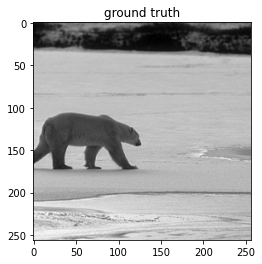

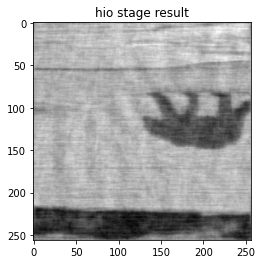

load checkpoint: ./drive/My Drive/checkpoints_dnn1_MSENew/epoch-615.pkl


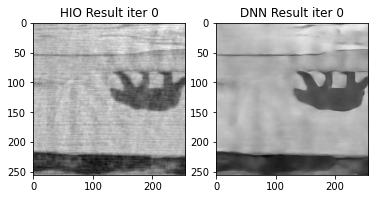

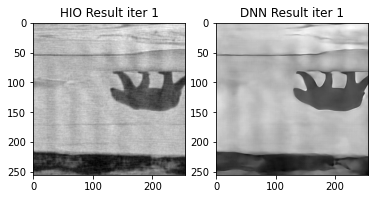

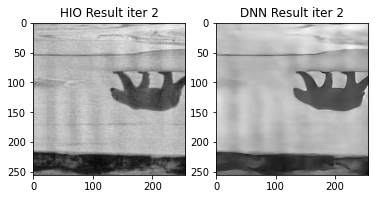

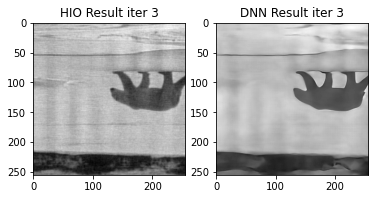

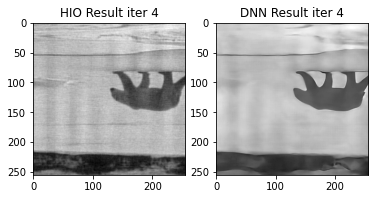

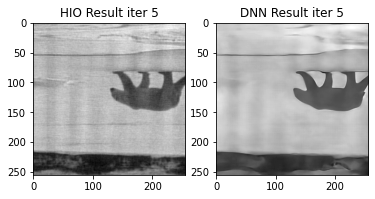

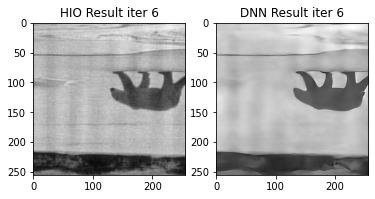

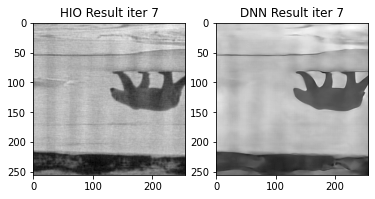

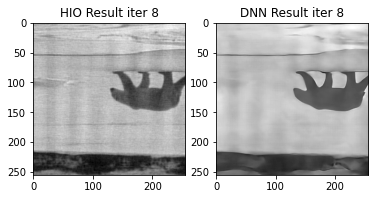

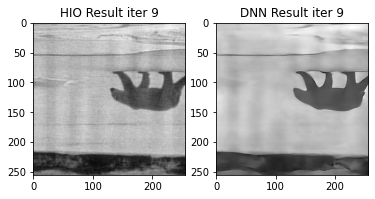

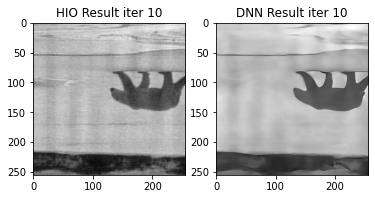

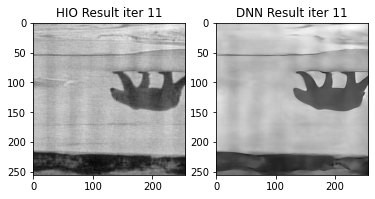

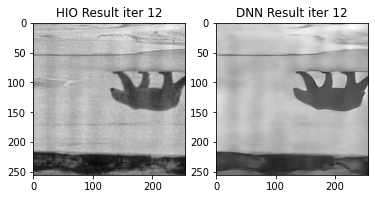

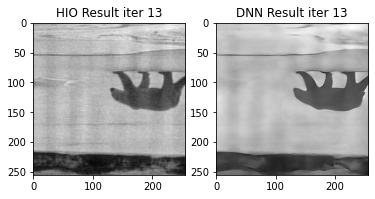

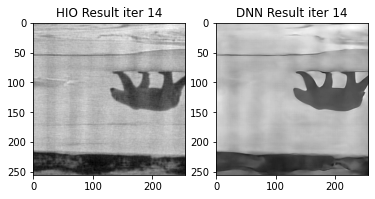

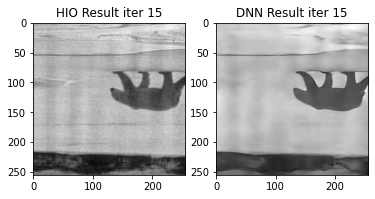

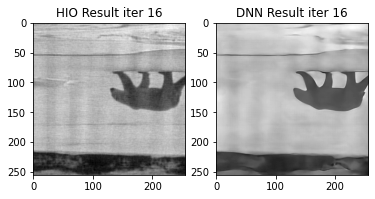

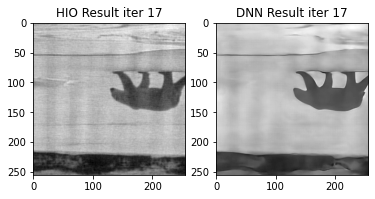

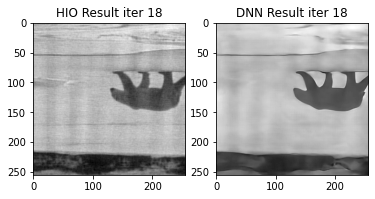

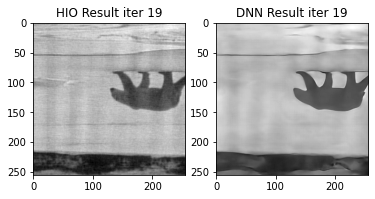

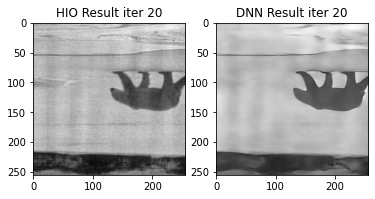

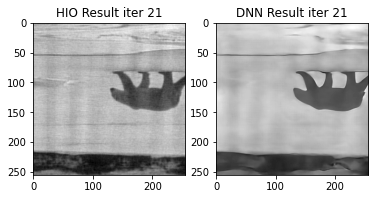

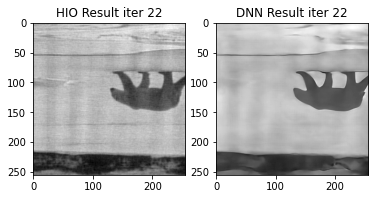

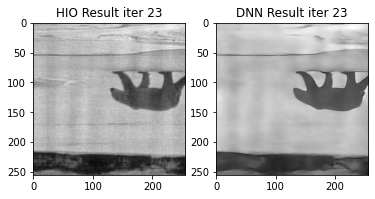

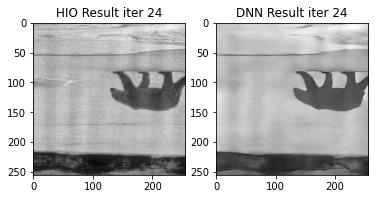

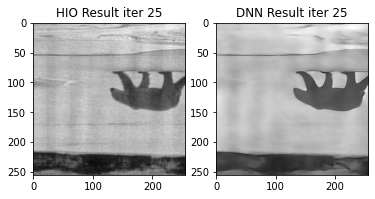

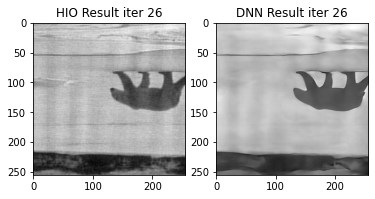

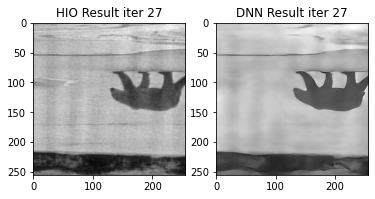

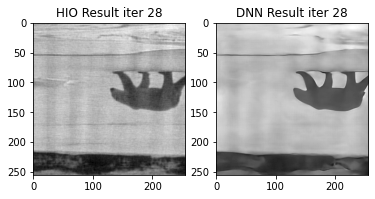

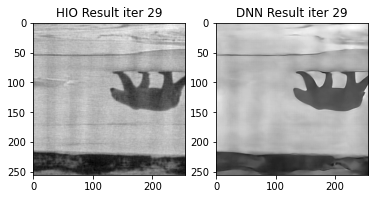

load checkpoint: ./drive/My Drive/checkpoints_dnn2_transfer/epoch-201.pkl


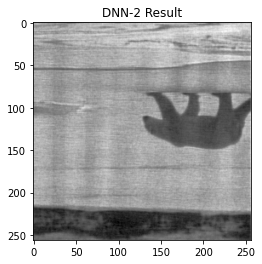

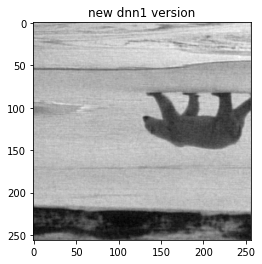

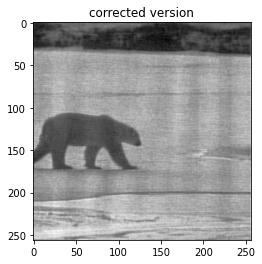

|| first hio stage 14.52:
psnr: 25.265000895697483
ssim: 0.5661315236277384
|| iterative stage 11.10:
psnr: 29.27892853163266
ssim: 0.7815904577847128
|| developed method 29.10:
psnr: 15.124483249377178
ssim: 0.7423812029609067
|| developed method 29.10:
psnr: 31.169521969533672
ssim: 0.8313410311510165


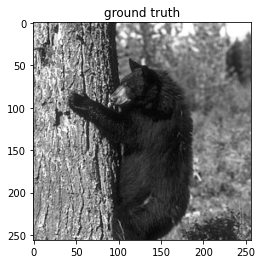

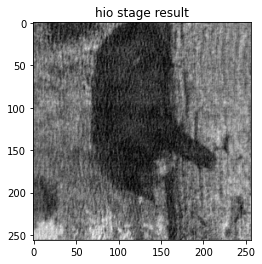

load checkpoint: ./drive/My Drive/checkpoints_dnn1_MSENew/epoch-615.pkl


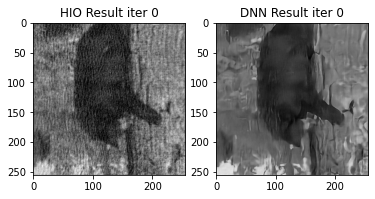

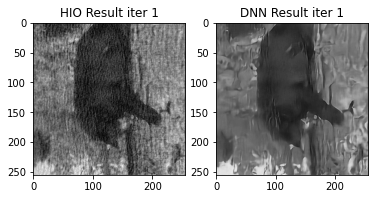

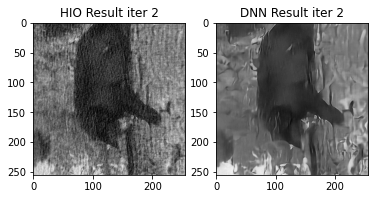

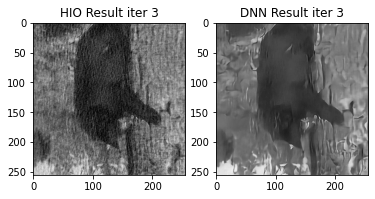

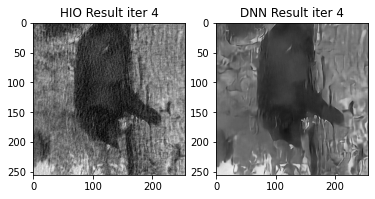

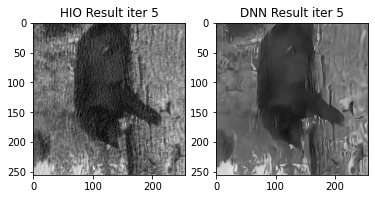

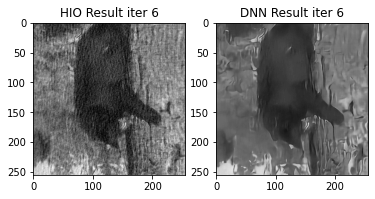

KeyboardInterrupt: ignored

In [ ]:
import sys
sys.path.insert(0, './drive/My Drive/fbpconvnet')

from model import FBPCONVNet
from utils import load_checkpoint, load_data, cmap_convert, rsnr, fienup_phase_retrieval
import os
import torch
import math
import torchvision
from argparse import Namespace
import numpy as np
import cupy as cp
from numpy import linalg as LA
import mat73
import imageio
import matplotlib.pyplot as plt
import time
import skimage.metrics

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = Namespace()
config.checkpoint_dir='./drive/My Drive/checkpoints_dnn1_MSENew/'
config.checkpoint_dir_2='./drive/My Drive/checkpoints_dnn2_MSENeww/'
config.checkpoint_dirnets='./drive/My Drive/checkpoints_dnn1new/'

test_dataset = torch.load('./drive/My Drive/test_dataset/orig_test.pt').cpu()
test_length = test_dataset.shape[0]

psnr_hio, ssim_hio, psnr_iter, ssim_iter, psnr_final, ssim_final, psnr_new, ssim_new, t_hio, t_iter, t_final = [], [], [], [], [], [], [], [], [], [], []
save.counter = 0




fbp_conv_nets = torch.nn.ModuleList()
fbp_conv_nets.append(FBPCONVNet().to(device))
fbp_conv_nets.append(FBPCONVNet().to(device))
fbp_conv_nets.append(FBPCONVNet().to(device))

# load check_point
if os.path.exists(config.checkpoint_dirnets) and len(os.listdir(config.checkpoint_dirnets)) > 0:
    fbp_conv_nets, _, _ = load_checkpoint(fbp_conv_nets, optimizer=None, checkpoint_dir=config.checkpoint_dirnets)






for ch in range(test_length):
  # test image
  image_ = test_dataset[ch].squeeze()
  SamplingRateSqrt = 2
  padded_zero = (np.array(image_.shape)*(SamplingRateSqrt-1)/2).astype(np.int)
  image_padded_ = np.pad(image_, padded_zero, 'constant') # oversampling
  mask = np.pad(np.ones(image_.shape), padded_zero, 'constant') # HIO mask
  mask_slice = (slice(padded_zero[0], padded_zero[0]+image_.shape[0]), slice(padded_zero[1], padded_zero[1]+image_.shape[1]))
  normalization = np.sqrt(image_.shape[0]*image_.shape[1]) * SamplingRateSqrt**2
  fourier_oversampled_ = (np.fft.fft2(image_padded_)/(normalization))

  plt.imshow(image_, cmap='gray')
  plt.title('ground truth')
  plt.show()

  # add noise
  alpha = 3
  intensity_noise = alpha*np.multiply(np.abs(fourier_oversampled_), np.random.randn(*fourier_oversampled_.shape))
  y2 = np.square(np.abs(fourier_oversampled_)) + intensity_noise
  y2 = np.multiply(y2, y2>0)
  y = np.sqrt(y2)

  t_0 = time.time()
  hio_res = hio_stage(y)
  t_hio.append(time.time() - t_0)
  iter_res = iterative(hio_res, y)
  t_iter.append(time.time() - t_hio[-1] - t_0)
  final = dnn2(iter_res)
  t_final.append(time.time() - t_0)





  tmp0 = torch.tensor(hio_res).unsqueeze(dim=0).unsqueeze(dim=0).float()
  for a in range(18):
    output0 = cmap_convert(fbp_conv_nets[int(a/6)](tmp0.to(device)).squeeze().squeeze())
    image_padded_iter = np.pad(output0, padded_zero, 'constant')
    tmp0 = fienup_phase_retrieval(y,
                                  steps=5,
                                  mask=mask,
                                  verbose=False,
                                  x_init=image_padded_iter,
                                  SamplingRateSqrt=normalization)
    tmp0 = torch.tensor(tmp0[mask_slice]).unsqueeze(0).unsqueeze(0).float()
    
  newdnn_res = tmp0.squeeze().squeeze().numpy()
  plt.imshow(newdnn_res, cmap='gray')
  plt.title('new dnn1 version')
  plt.show()



  if(skimage.metrics.peak_signal_noise_ratio(np.asarray(image_, dtype=np.uint8), np.flip(np.asarray(final, dtype=np.uint8))) > skimage.metrics.peak_signal_noise_ratio(np.asarray(image_, dtype=np.uint8), np.asarray(final, dtype=np.uint8))):
    # is twin image
    hio_res = np.flip(hio_res)
    iter_res = np.flip(iter_res)
    final = np.flip(final)
    newdnn_res = np.flip(newdnn_res)
    plt.imshow(final, cmap='gray')
    plt.title('corrected version')
    plt.show()
    
  # compare
  psnr_hio.append(skimage.metrics.peak_signal_noise_ratio(np.asarray(image_, dtype=np.intc), np.asarray(hio_res, dtype=np.intc), data_range=255))
  ssim_hio.append(skimage.metrics.structural_similarity(np.asarray(image_, dtype=np.intc), np.asarray(hio_res, dtype=np.intc), data_range=255))

  psnr_iter.append(skimage.metrics.peak_signal_noise_ratio(np.asarray(image_, dtype=np.intc), np.asarray(iter_res, dtype=np.intc), data_range=255))
  ssim_iter.append(skimage.metrics.structural_similarity(np.asarray(image_, dtype=np.intc), np.asarray(iter_res, dtype=np.intc), data_range=255))

  psnr_final.append(skimage.metrics.peak_signal_noise_ratio(np.asarray(image_, dtype=np.intc), np.asarray(final, dtype=np.intc), data_range=255))
  ssim_final.append(skimage.metrics.structural_similarity(np.asarray(image_, dtype=np.intc), np.asarray(final, dtype=np.intc), data_range=255))

  psnr_new.append(skimage.metrics.peak_signal_noise_ratio(np.asarray(image_, dtype=np.intc), np.asarray(newdnn_res, dtype=np.intc), data_range=255))
  ssim_new.append(skimage.metrics.structural_similarity(np.asarray(image_, dtype=np.intc), np.asarray(newdnn_res, dtype=np.intc), data_range=255))

  save(ch+1)

histograms

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

path = './drive/My Drive/test_results_L1/16'
testSize = 91
psnr_hio       = np.array(torch.load(path+'/psnr_hio.pt'))[0:testSize]
ssim_hio       = np.array(torch.load(path+'/ssmi_hio.pt'))[0:testSize]
psnr_iter      = np.array(torch.load(path+'/psnr_iter.pt'))[0:testSize]
ssim_iter      = np.array(torch.load(path+'/ssim_iter.pt'))[0:testSize]
psnr_developed = np.array(torch.load(path+'/psnr_final.pt'))[0:testSize]
ssim_developed = np.array(torch.load(path+'/ssim_final.pt'))[0:testSize]
t_hio          = np.array(torch.load(path+'/t_hio.pt'))[0:testSize]
t_iter         = np.array(torch.load(path+'/t_iter.pt'))[0:testSize]
t_final        = np.array(torch.load(path+'/t_final.pt'))[0:testSize]

plt.figure(figsize=[10,20])

plt.rcParams.update({'font.weight': 'bold'})
alpha = .6
linewidth = 2
linewidth_mean = 2
bins_psnr = 30
bins_ssim = 30

plt1 = plt.subplot(4,2,1)
plt1.set_axisbelow(True)
plt.grid(alpha=0.5)
plt.hist(psnr_hio, bins=bins_psnr, range=(0,40), color='#545454', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.legend(['HIO'])
plt.axvline(psnr_hio.mean(), color='k', linestyle='dashed', linewidth=linewidth_mean)

plt1 = plt.subplot(4,2,2)
plt1.set_axisbelow(True)
plt.grid(alpha=0.5)
plt.hist(ssim_hio, bins=bins_ssim, range=(0,1), color='#545454', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.legend(['HIO'])
plt.axvline(ssim_hio.mean(), color='k', linestyle='dashed', linewidth=linewidth_mean)

plt1 = plt.subplot(4,2,3)
plt1.set_axisbelow(True)
plt.grid(alpha=0.5)
plt.hist(psnr_iter, bins=bins_psnr, range=(0,40), color='#969696', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.legend(['Iterative Stage'])
plt.axvline(psnr_iter.mean(), color='k', linestyle='dashed', linewidth=linewidth_mean)

plt1 = plt.subplot(4,2,4)
plt1.set_axisbelow(True)
plt.grid(alpha=0.5)
plt.hist(ssim_iter, bins=bins_ssim, range=(0,1), color='#969696', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.legend(['Iterative Stage'])
plt.axvline(ssim_iter.mean(), color='k', linestyle='dashed', linewidth=linewidth_mean)

plt1 = plt.subplot(4,2,5)
plt1.set_axisbelow(True)
plt.grid(alpha=0.5)
plt.hist(psnr_developed, bins=bins_psnr, range=(0,40), color='#dddddd', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.legend(['Final Result'])
plt.axvline(psnr_developed.mean(), color='k', linestyle='dashed', linewidth=linewidth_mean)

plt1 = plt.subplot(4,2,6)
plt1.set_axisbelow(True)
plt.grid(alpha=0.5)
plt.hist(ssim_developed, bins=bins_ssim, range=(0,1), color='#dddddd', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.legend(['Final Result'])
plt.axvline(ssim_developed.mean(), color='k', linestyle='dashed', linewidth=linewidth_mean)

# all
plt1 = plt.subplot(4,2,7)
plt1.set_axisbelow(True)
plt.grid(alpha=0.5)
plt.hist(psnr_hio, bins=bins_psnr, range=(0,40), color='#545454', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.hist(psnr_iter, bins=bins_psnr, range=(0,40), color='#969696', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.hist(psnr_developed, bins=bins_psnr, range=(0,40), color='#dddddd', alpha=alpha, linewidth=linewidth, edgecolor='black')

plt1 = plt.subplot(4,2,8)
plt1.set_axisbelow(True)
plt.grid(alpha=0.5)
plt.hist(ssim_hio, bins=bins_ssim, range=(0,1), color='#545454', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.hist(ssim_iter, bins=bins_ssim, range=(0,1), color='#969696', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.hist(ssim_developed, bins=bins_ssim, range=(0,1), color='#dddddd', alpha=alpha, linewidth=linewidth, edgecolor='black')

plt.show()

print('\t \t SSIM \t || PSNR \t || time (s)')
print(f'HIO Stage: \t {ssim_hio.mean():.4f}  || {psnr_hio.mean():.4f} \t || {t_hio.mean():.4f}')
print(f'Iterative Stage: {ssim_iter.mean():.4f}  || {psnr_iter.mean():.4f} \t || {t_iter.mean():.4f}')
print(f'Final Result: \t {ssim_developed.mean():.4f}  || {psnr_developed.mean():.4f} \t || {t_final.mean():.4f}')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

path = './drive/My Drive/test_results_L1_5iters'
psnr_hio       = np.array(torch.load(path+'/psnr_hio.pt'))
ssim_hio       = np.array(torch.load(path+'/ssmi_hio.pt'))
psnr_iter      = np.array(torch.load(path+'/psnr_iter.pt'))
ssim_iter      = np.array(torch.load(path+'/ssim_iter.pt'))
psnr_developed = np.array(torch.load(path+'/psnr_final.pt'))
ssim_developed = np.array(torch.load(path+'/ssim_final.pt'))
t_hio          = np.array(torch.load(path+'/t_hio.pt'))
t_iter         = np.array(torch.load(path+'/t_iter.pt'))
t_final        = np.array(torch.load(path+'/t_final.pt'))

plt.figure(figsize=[10,20])

plt.rcParams.update({'font.weight': 'bold'})
alpha = .6
linewidth = 2
linewidth_mean = 2
bins_psnr = 30
bins_ssim = 30

plt1 = plt.subplot(4,2,1)
plt1.set_axisbelow(True)
plt.grid(alpha=0.5)
plt.hist(psnr_hio, bins=bins_psnr, range=(0,40), color='#545454', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.legend(['HIO'])
plt.axvline(psnr_hio.mean(), color='k', linestyle='dashed', linewidth=linewidth_mean)

plt1 = plt.subplot(4,2,2)
plt1.set_axisbelow(True)
plt.grid(alpha=0.5)
plt.hist(ssim_hio, bins=bins_ssim, range=(0,1), color='#545454', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.legend(['HIO'])
plt.axvline(ssim_hio.mean(), color='k', linestyle='dashed', linewidth=linewidth_mean)

plt1 = plt.subplot(4,2,3)
plt1.set_axisbelow(True)
plt.grid(alpha=0.5)
plt.hist(psnr_iter, bins=bins_psnr, range=(0,40), color='#969696', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.legend(['Iterative Stage'])
plt.axvline(psnr_iter.mean(), color='k', linestyle='dashed', linewidth=linewidth_mean)

plt1 = plt.subplot(4,2,4)
plt1.set_axisbelow(True)
plt.grid(alpha=0.5)
plt.hist(ssim_iter, bins=bins_ssim, range=(0,1), color='#969696', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.legend(['Iterative Stage'])
plt.axvline(ssim_iter.mean(), color='k', linestyle='dashed', linewidth=linewidth_mean)

plt1 = plt.subplot(4,2,5)
plt1.set_axisbelow(True)
plt.grid(alpha=0.5)
plt.hist(psnr_developed, bins=bins_psnr, range=(0,40), color='#dddddd', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.legend(['Final Result'])
plt.axvline(psnr_developed.mean(), color='k', linestyle='dashed', linewidth=linewidth_mean)

plt1 = plt.subplot(4,2,6)
plt1.set_axisbelow(True)
plt.grid(alpha=0.5)
plt.hist(ssim_developed, bins=bins_ssim, range=(0,1), color='#dddddd', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.legend(['Final Result'])
plt.axvline(ssim_developed.mean(), color='k', linestyle='dashed', linewidth=linewidth_mean)

# all
plt1 = plt.subplot(4,2,7)
plt1.set_axisbelow(True)
plt.grid(alpha=0.5)
plt.hist(psnr_hio, bins=bins_psnr, range=(0,40), color='#545454', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.hist(psnr_iter, bins=bins_psnr, range=(0,40), color='#969696', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.hist(psnr_developed, bins=bins_psnr, range=(0,40), color='#dddddd', alpha=alpha, linewidth=linewidth, edgecolor='black')

plt1 = plt.subplot(4,2,8)
plt1.set_axisbelow(True)
plt.grid(alpha=0.5)
plt.hist(ssim_hio, bins=bins_ssim, range=(0,1), color='#545454', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.hist(ssim_iter, bins=bins_ssim, range=(0,1), color='#969696', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.hist(ssim_developed, bins=bins_ssim, range=(0,1), color='#dddddd', alpha=alpha, linewidth=linewidth, edgecolor='black')

plt.show()

print('\t \t SSIM \t || PSNR \t || time (s)')
print(f'HIO Stage: \t {ssim_hio.mean():.4f}  || {psnr_hio.mean():.4f} \t || {t_hio.mean():.4f}')
print(f'Iterative Stage: {ssim_iter.mean():.4f}  || {psnr_iter.mean():.4f} \t || {t_iter.mean():.4f}')
print(f'Final Result: \t {ssim_developed.mean():.4f}  || {psnr_developed.mean():.4f} \t || {t_final.mean():.4f}')